In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set. 
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    (c['name'], c["type"])
    
columns = inspector.get_columns('station')
for c in columns:
    (c['name'], c["type"])

latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest)

('2017-08-23',)


In [11]:
lastdate = dt.datetime.strptime(latest[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
querydt = dt.date(lastdate.year - 1, lastdate.month, lastdate.day)
querydt

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
select = [Measurement.date, Measurement.prcp]
result =  session.query(*select).filter(Measurement.date >= querydt).all()

# Perform a query to retrieve the date and precipitation scores
select = [Measurement.date, Measurement.prcp]
result =  session.query(*select).filter(Measurement.date >= querydt).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results = pd.DataFrame(result, columns= ['Date','Precipitation'])

df_results.head()

# Sort the dataframe by date
df_results = df_results.dropna(how='any').sort_values(['Date'], ascending = True).set_index("Date")
df_results.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


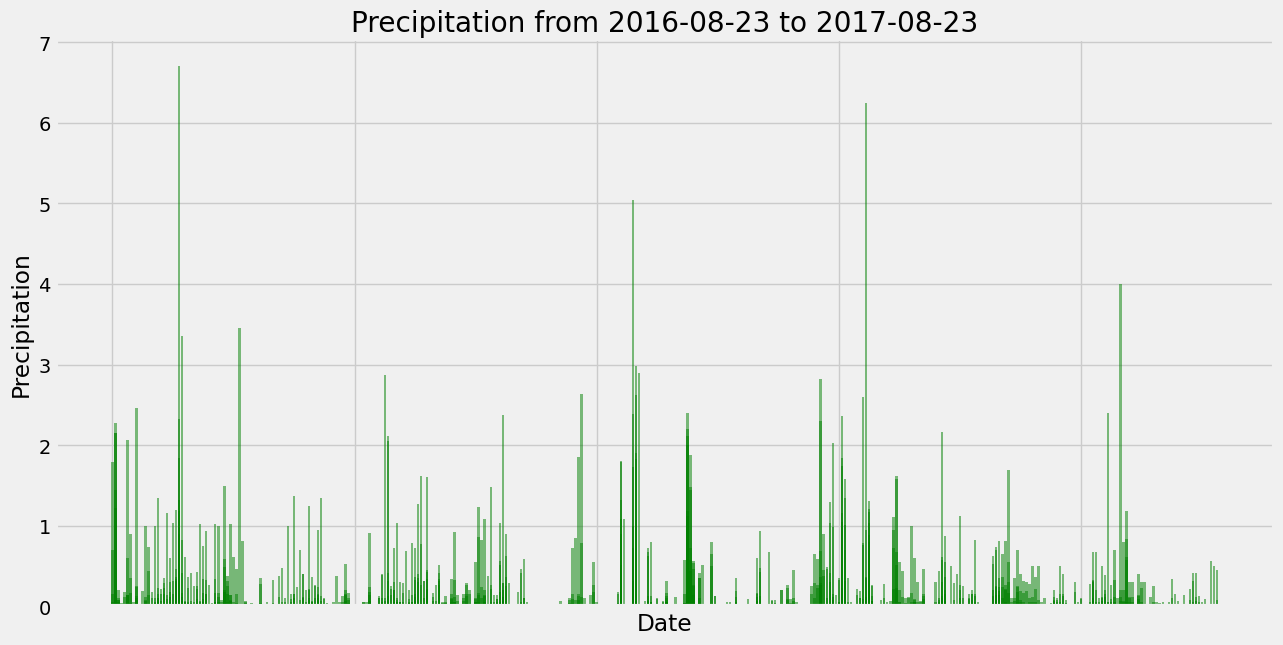

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
datex = df_results.index.tolist()
precipy = df_results.Precipitation.tolist()

plt.figure(figsize = (14,7))
plt.bar(datex,precipy, color = 'g', alpha = 0.5, align = 'center', label = 'Precipitaiton')

plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydt} to {latest[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which = 'major', axis = 'both', linestyle = '-')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query( Measurement.station , func.count(Measurement.station)).group_by( Measurement.station ).\
               order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stations = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
                      func.avg(Measurement.tobs)).\
                      filter(Measurement.station == 'USC00519281' ).all()

temp_stations

[(54.0, 85.0, 71.66378066378067)]

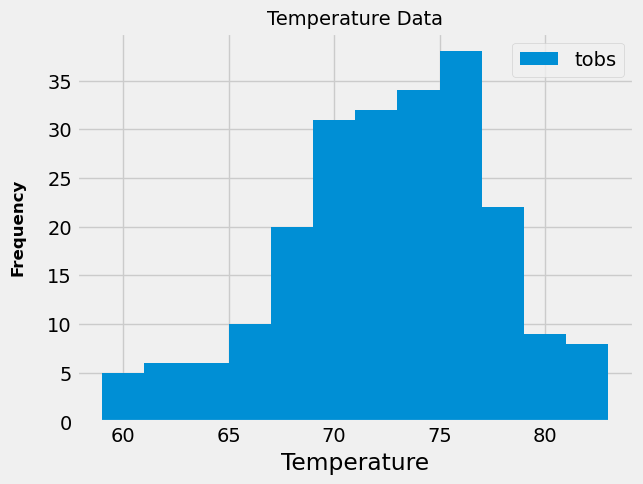

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastest_dt = session.query (Measurement.date).filter(Measurement.station == 'USC00519281').\
          order_by(Measurement.date.desc()).first()

results_temp =  session.query(Measurement.tobs).\
                          filter(Measurement.station == 'USC00519281' ).\
                          filter(Measurement.date >= '2017,8,23').all()

df_temp=pd.DataFrame(results_temp)

hist = df_temp['tobs'].hist(bins=12)
plt.title("Temperature Data" ,
           size = 14)
plt.xlabel('Temperature')
plt.ylabel('Frequency', labelpad=16, weight='bold', size=12)
labels = ['tobs']
plt.legend(labels)

plt.show()

# Close Session

In [19]:
# Close Session
session.close()